In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from community import community_louvain
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math
from collections import Counter
import pandas as pd

In [2]:
!pip install python-louvain

In [2]:
file_path = 'data/wikiconflict.edges'

try:
    G = nx.read_edgelist(
        file_path,
        delimiter=',',
        # Correção crucial: Use 'Peso' (singular) em vez de 'Pesos'
        data=(('Peso', float), ('Timestamp', int)), 
        create_using=nx.DiGraph
    )

    print(f"Número de nós: {G.number_of_nodes()}")
    print(f"Número de arestas: {G.number_of_edges()}")

except FileNotFoundError:
    print(f"ERRO: Arquivo '{file_path}' não encontrado. Verifique se o arquivo está na pasta 'data'.")

Número de nós: 116836
Número de arestas: 2027871


In [3]:
G_conc_novo = nx.DiGraph()
G_conf_novo = nx.DiGraph()

G_conc_novo.add_nodes_from(G.nodes(data=True))
G_conf_novo.add_nodes_from(G.nodes(data=True))

for u, v, data in G.edges(data=True):
    peso = data.get('Peso', 0)

    if peso > 0:
        G_conc_novo.add_edge(u, v, **data)

    elif peso < 0:
        G_conf_novo.add_edge(u, v, **data)

isolados_conc = list(nx.isolates(G_conc_novo))
G_conc_limpo = G_conc_novo.copy()
G_conc_limpo.remove_nodes_from(isolados_conc)

isolados_conf = list(nx.isolates(G_conf_novo))
G_conf_limpo = G_conf_novo.copy()
G_conf_limpo.remove_nodes_from(isolados_conf)

print(f"Laços de CONCORDÂNCIA: {G_conc_limpo.number_of_edges()}")
print(f"Laços de CONFLITO: {G_conf_limpo.number_of_edges()}")

Laços de CONCORDÂNCIA: 774785
Laços de CONFLITO: 1251861


In [5]:
num_arestas_conc = G_conc_limpo.number_of_edges()
num_arestas_conf = G_conf_limpo.number_of_edges()
print(f"Total de Nós no Grafo G: {G.number_of_nodes()}")
print(f"Total de Arestas no Grafo G: {G.number_of_edges()}")
print(f"Nós ATIVOS em Concordância: {G_conc_limpo.number_of_nodes()}")
print(f"Nós ATIVOS em Conflito: {G_conf_limpo.number_of_nodes()}")
print(f"Total de Laços de CONCORDÂNCIA: {num_arestas_conc}")
print(f"Total de Laços de CONFLITO: {num_arestas_conf}")

Total de Nós no Grafo G: 116836
Total de Arestas no Grafo G: 2027871
Nós ATIVOS em Concordância: 48250
Nós ATIVOS em Conflito: 115822
Total de Laços de CONCORDÂNCIA: 774785
Total de Laços de CONFLITO: 1251861


In [6]:
componentes_conc = list(nx.weakly_connected_components(G_conc_limpo))
componentes_conc_maior = max(componentes_conc, key=len)

print(f"Número de 'Panelinhas' de Concordância: {len(componentes_conc)}")
print(f"Tamanho da Maior Componente (Coerência): {len(componentes_conc_maior)} nós")

componentes_conf = list(nx.weakly_connected_components(G_conf_limpo))
componentes_conf_maior = max(componentes_conf, key=len)

print(f"Número de 'Panelinhas' de Conflito: {len(componentes_conf)}")
print(f"Tamanho da Maior Componente (Coerência): {len(componentes_conf_maior)} nós")

Número de 'Panelinhas' de Concordância: 358
Tamanho da Maior Componente (Coerência): 47366 nós
Número de 'Panelinhas' de Conflito: 1799
Tamanho da Maior Componente (Coerência): 112070 nós


In [13]:
grau_conc = G_conc_limpo.degree()

grau_conc_dict = dict(grau_conc)
hubs_conc = sorted(grau_conc_dict.items(), key=lambda item: item[1], reverse=True)

print("\nTop 5 nós da Concordância")
for node_id, grau in hubs_conc[:5]:
    print(f"ID do Usuário: {node_id}, Grau de Concordância: {grau}")

grau_conf = G_conf_limpo.degree()

grau_conf_dict = dict(grau_conf)
hubs_conf = sorted(grau_conf_dict.items(), key=lambda item: item[1], reverse=True)

print("\nTop 5 hubs da Conflito")
for node_id, grau in hubs_conf[:5]:
    print(f"ID do Usuário: {node_id}, Grau de Conflito: {grau}")


Top 5 nós da Concordância
ID do Usuário: 4215, Grau de Concordância: 18725
ID do Usuário: 491, Grau de Concordância: 13441
ID do Usuário: 5857, Grau de Concordância: 10369
ID do Usuário: 830, Grau de Concordância: 9692
ID do Usuário: 2742, Grau de Concordância: 8873

Top 5 hubs da Conflito
ID do Usuário: 376, Grau de Conflito: 4818
ID do Usuário: 2727, Grau de Conflito: 2477
ID do Usuário: 164, Grau de Conflito: 2068
ID do Usuário: 3493, Grau de Conflito: 1980
ID do Usuário: 359, Grau de Conflito: 1769


In [10]:
G_conc_maior = G_conc_limpo.subgraph(componentes_conc_maior)

print(f"Nós na Componente Conexa Maior (CCM) de Concordância: {G_conc_maior.number_of_nodes()}")
print(f"Arestas na CCM de Concordância: {G_conc_maior.number_of_edges()}")
pos_ccm = nx.spring_layout(G_conc_maior, k=0.15, iterations=50)
plt.figure(figsize=(10, 10))
nx.draw(G_conc_maior, pos_ccm, with_labels=False,
        node_size=1, node_color='darkgreen', alpha=0.6, ax=plt.gca())
nx.draw_networkx_edges(G_conc_maior, pos_ccm, edge_color='green', alpha=0.1,
                       arrowstyle='->', arrowsize=3)

plt.title(f"Componente Conexa Maior da Rede de Concordância ({G_conc_maior.number_of_nodes()} Nós)", fontsize=14)
plt.axis('off')
plt.show()

Nós na Componente Conexa Maior (CCM) de Concordância: 47366
Arestas na CCM de Concordância: 774252


KeyboardInterrupt: 

In [14]:
hubs_conc_ids = ["4215", "491", "5857", "830", "2742"]
hubs_conf_ids = ["376", "2727", "164", "3493", "359"]

print("\n- ANÁLISE DE PAPÉIS: REVISOR (SAÍDA) vs. AUTORIDADE (ENTRADA)")

print("Hubs de CONCORDÂNCIA:")
for node_id in hubs_conc_ids:
    try:
        in_d = G_conc_limpo.in_degree[node_id]  
        out_d = G_conc_limpo.out_degree[node_id]
        
        total = in_d + out_d
        
        if in_d > 0:
            razao = out_d / in_d
        else:
            razao = out_d 
        
        print(f"ID {node_id} (Total: {total})")
        print(f"   - Recebeu (In): {in_d} | Fez (Out): {out_d}")
        
    except KeyError:
        print(f"ERRO: O nó '{node_id}' não foi encontrado no grafo conc.")

print("\nHubs de CONFLITO:")
for node_id in hubs_conf_ids:
    try:
        in_d = G_conf_limpo.in_degree[node_id]
        out_d = G_conf_limpo.out_degree[node_id]
        
        total = in_d + out_d
        
        print(f"ID {node_id} (Total: {total})")
        print(f"   - Foi Revertido (In): {in_d} | Reverteu Outros (Out): {out_d}")
    except KeyError:
        print(f"ERRO: O nó '{node_id}' não foi encontrado no grafo G_conf_limpo.")


- ANÁLISE DE PAPÉIS: REVISOR (SAÍDA) vs. AUTORIDADE (ENTRADA)
Hubs de CONCORDÂNCIA:
ID 4215 (Total: 18725)
   - Recebeu (In): 894 | Fez (Out): 17831
ID 491 (Total: 13441)
   - Recebeu (In): 149 | Fez (Out): 13292
ID 5857 (Total: 10369)
   - Recebeu (In): 892 | Fez (Out): 9477
ID 830 (Total: 9692)
   - Recebeu (In): 151 | Fez (Out): 9541
ID 2742 (Total: 8873)
   - Recebeu (In): 623 | Fez (Out): 8250

Hubs de CONFLITO:
ID 376 (Total: 4818)
   - Foi Revertido (In): 23 | Reverteu Outros (Out): 4795
ID 2727 (Total: 2477)
   - Foi Revertido (In): 47 | Reverteu Outros (Out): 2430
ID 164 (Total: 2068)
   - Foi Revertido (In): 5 | Reverteu Outros (Out): 2063
ID 3493 (Total: 1980)
   - Foi Revertido (In): 53 | Reverteu Outros (Out): 1927
ID 359 (Total: 1769)
   - Foi Revertido (In): 21 | Reverteu Outros (Out): 1748


In [4]:
edges_pos = [(u, v, d) for u, v, d in G.edges(data=True) if d.get('Peso', 0) > 0]

G_positive = nx.Graph()
G_positive.add_nodes_from(G.nodes())
G_positive.add_edges_from(edges_pos)

partition = community_louvain.best_partition(G_positive, weight='Peso') 

modularidade = community_louvain.modularity(partition, G_positive, weight='Peso')
num_comunidades = len(set(partition.values()))

print(f"Modularidade (Coesão dos Grupos): {modularidade:.4f}")
print(f"Número de Comunidades Identificadas: {num_comunidades}")

# 4. Salvar essa informação no Grafo para exportar pro Gephi depois
nx.set_node_attributes(G, partition, 'community')

Modularidade (Coesão dos Grupos): 0.4037
Número de Comunidades Identificadas: 68971


In [6]:
df_nodes = pd.DataFrame.from_dict(partition, orient='index', columns=['Community'])
df_nodes.reset_index(inplace=True)
df_nodes.rename(columns={'index': 'Id', 'Community': 'Modularity Class'}, inplace=True)
df_nodes['Label'] = df_nodes['Id']

df_nodes.to_csv('gephi_nodes_comunidades.csv', index=False)
print("Arquivo de NÓS (gephi_nodes_comunidades.csv) salvo com as comunidades")

edges_data = []
for u, v, d in G.edges(data=True):
    edges_data.append({
        'Source': u,
        'Target': v,
        'Weight': d.get('Peso', 0),
        'Timestamp': d.get('Timestamp', '')
    })

df_edges = pd.DataFrame(edges_data)
df_edges['Type'] = 'Directed'

df_edges.to_csv('gephi_edges_completo.csv', index=False)
print("Arquivo de ARESTAS (gephi_edges_completo.csv) salvo com conflitos e concordâncias")

Arquivo de NÓS (gephi_nodes_comunidades.csv) salvo com as comunidades
Arquivo de ARESTAS (gephi_edges_completo.csv) salvo com conflitos e concordâncias


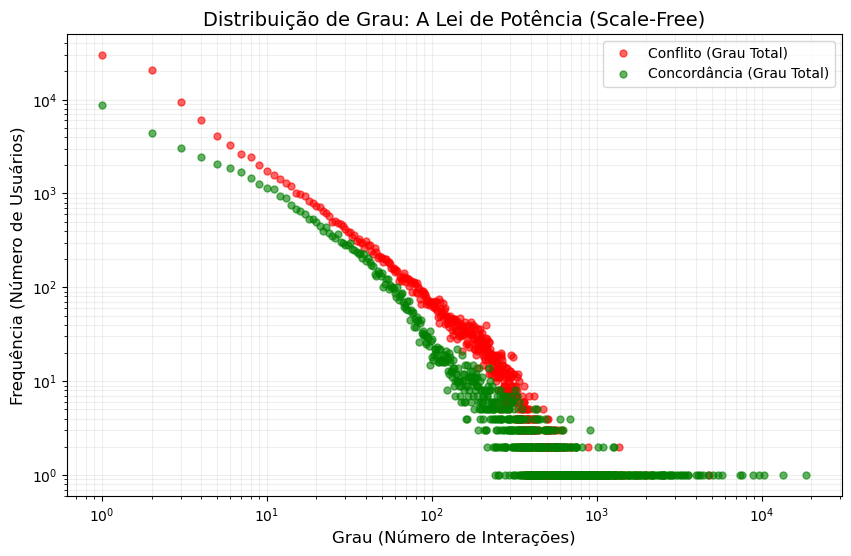

In [12]:
def plot_degree_distribution(G, label, color):
    degrees = [d for n, d in G.degree()]
    
    values, counts = np.unique(degrees, return_counts=True)
    
    plt.loglog(values, counts, 'o', label=label, color=color, alpha=0.6, markersize=5)

plt.figure(figsize=(10, 6))

plot_degree_distribution(G_conf_limpo, "Conflito (Grau Total)", "red")

plot_degree_distribution(G_conc_limpo, "Concordância (Grau Total)", "green")

plt.title("Distribuição de Grau: A Lei de Potência (Scale-Free)", fontsize=14)
plt.ylabel("Frequência (Número de Usuários)", fontsize=12)
plt.xlabel("Grau (Número de Interações)", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [12]:
primeiro_no = list(G.nodes())[0]
tipo_no = type(primeiro_no)

hubs_conc_raw = [4215, 491, 5857, 830, 2742]
hubs_conf_raw = [376, 2727, 164, 3493, 359]

if tipo_no == str:
    print("-> Convertendo lista de hubs para TEXTO (String) para coincidir.")
    hubs_conc = [str(x) for x in hubs_conc_raw]
    hubs_conf = [str(x) for x in hubs_conf_raw]
else:
    print("-> Mantendo lista de hubs como NÚMEROS (Int).")
    hubs_conc = hubs_conc_raw
    hubs_conf = hubs_conf_raw

betweenness_exact = nx.betweenness_centrality(
    G, 
    k=None, 
    normalized=True, 
    weight='Peso', 
    seed=42
)

nome_arquivo = 'betweenness_exact_FULL.pkl'
with open(nome_arquivo, 'wb') as f:
    pickle.dump(betweenness_exact, f)

print(f"Resultados salvos em '{nome_arquivo}'.")

print(">>> Hubs de CONCORDÂNCIA:")
for node_id in hubs_conc:
    valor = betweenness_exact.get(node_id, -1.0) 
    print(f"ID {node_id}: {valor:.5e}")

print("\n>>> Hubs de CONFLITO:")
for node_id in hubs_conf:
    valor = betweenness_exact.get(node_id, -1.0)
    print(f"ID {node_id}: {valor:.5e}")

-> Convertendo lista de hubs para TEXTO (String) para coincidir.
Resultados salvos em 'betweenness_exact_FULL.pkl'.
>>> Hubs de CONCORDÂNCIA:
ID 4215: 7.60490e-04
ID 491: 2.15472e-04
ID 5857: 1.38524e-04
ID 830: 8.52680e-05
ID 2742: 1.73490e-04

>>> Hubs de CONFLITO:
ID 376: 2.19005e-05
ID 2727: 2.57362e-04
ID 164: 2.83803e-07
ID 3493: 1.34845e-04
ID 359: 3.38466e-06


In [11]:
G_social = G_conc_limpo.to_undirected()

N = G_social.number_of_nodes()
E = G_social.number_of_edges()
k_medio = (2 * E) / N

C_real = nx.average_clustering(G_social) 
print(f"-> Coeficiente de Clusterização Real (C_real): {C_real:.5f}")

if N > 0:
    C_random = k_medio / N
else:
    C_random = 0

print(f"-> Clusterização Teórica em Rede Aleatória (C_rand): {C_random:.5e}")

if C_random > 0:
    ratio = C_real / C_random
    print(f"A Clusterização Real é {ratio:.2f} vezes maior que a esperada no acaso.")
    
    if ratio > 10:
        print("A rede é ALTAMENTE clusterizada (Mundo Pequeno confirmado).")
    else:
        print("A rede tem baixa clusterização.")

-> Coeficiente de Clusterização Real (C_real): 0.24215
-> Clusterização Teórica em Rede Aleatória (C_rand): 6.65605e-04
A Clusterização Real é 363.80 vezes maior que a esperada no acaso.
A rede é ALTAMENTE clusterizada (Mundo Pequeno confirmado).


In [8]:
G_undirected = G_conc_limpo.to_undirected()
largest_cc_nodes = max(nx.connected_components(G_undirected), key=len)
LCC = G_undirected.subgraph(largest_cc_nodes).copy()

print(f"Componente Gigante Isolada com {LCC.number_of_nodes()} nós.")

num_samples = 47366
print(f"Calculando caminhos a partir de {num_samples} nós aleatórios...")

nodes_list = list(LCC.nodes())
sampled_sources = random.sample(nodes_list, num_samples)

path_lengths = []
diametro_estimado = 0

for source in sampled_sources:
    lengths = nx.single_source_shortest_path_length(LCC, source)
    
    max_len = max(lengths.values())
    if max_len > diametro_estimado:
        diametro_estimado = max_len
        
    path_lengths.extend(lengths.values())

avg_path = np.mean(path_lengths)
print(f"Distância Média Estimada: {avg_path:.4f}")
print(f"Diâmetro Estimado: {diametro_estimado}")

N_lcc = LCC.number_of_nodes()
log_n = math.log(N_lcc)

print(f"Distância esperada em rede aleatória (~ln N): {log_n:.2f}")

if avg_path < log_n * 2:
    print("CONCLUSÃO: O caminho é curto (Small World Confirmado).")
else:
    print("CONCLUSÃO: O caminho é longo.")

Componente Gigante Isolada com 47366 nós.
Calculando caminhos a partir de 47366 nós aleatórios...


KeyboardInterrupt: 

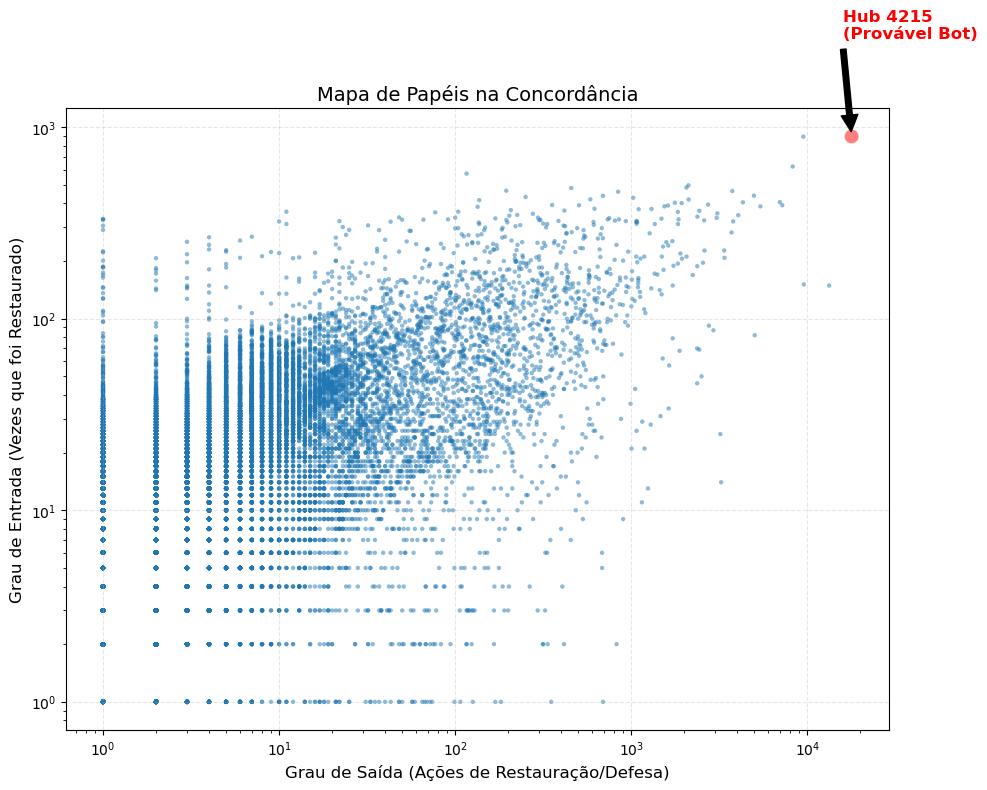

In [9]:
in_degrees = []
out_degrees = []
colors = []
sizes = []

hub_destaque = '4215'

for node in G_conc_limpo.nodes():
    in_d = G_conc_limpo.in_degree(node)
    out_d = G_conc_limpo.out_degree(node)
    
    in_degrees.append(in_d)
    out_degrees.append(out_d)
    
    if str(node) == hub_destaque:
        colors.append('red')
        sizes.append(100)
    else:
        colors.append('#1f77b4')
        sizes.append(10)
        
plt.figure(figsize=(10, 8))

plt.scatter(out_degrees, in_degrees, c=colors, s=sizes, alpha=0.5, edgecolors='none')

plt.title(f"Mapa de Papéis na Concordância", fontsize=14)
plt.xlabel("Grau de Saída (Ações de Restauração/Defesa)", fontsize=12)
plt.ylabel("Grau de Entrada (Vezes que foi Restaurado)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)

hub_in = G_conc_limpo.in_degree(hub_destaque)
hub_out = G_conc_limpo.out_degree(hub_destaque)

plt.annotate(f'Hub {hub_destaque}\n(Provável Bot)', 
             xy=(hub_out, hub_in), 
             xytext=(hub_out - 2000, hub_in + 2000), # Posição do texto
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold', color='red')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

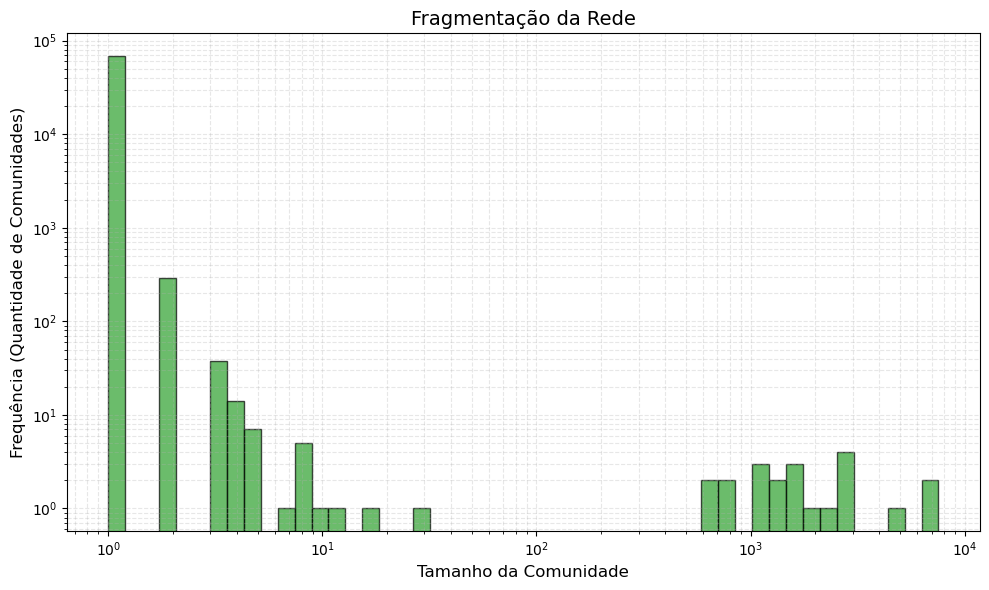

Total de Comunidades: 68969
Maior Comunidade: 7543 usuários
Comunidades com menos de 10 usuários: 68944


In [14]:
# partition = nx.get_node_attributes(G, 'community')

tamanhos = list(Counter(partition.values()).values())

plt.figure(figsize=(10, 6))

bins = np.logspace(np.log10(min(tamanhos)), np.log10(max(tamanhos)), 50)

plt.hist(tamanhos, bins=bins, color='#2ca02c', alpha=0.7, edgecolor='black')

plt.xscale('log')
plt.yscale('log')

plt.title("Fragmentação da Rede", fontsize=14)
plt.xlabel("Tamanho da Comunidade", fontsize=12)
plt.ylabel("Frequência (Quantidade de Comunidades)", fontsize=12)

plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total de Comunidades: {len(tamanhos)}")
print(f"Maior Comunidade: {max(tamanhos)} usuários")
print(f"Comunidades com menos de 10 usuários: {sum(1 for t in tamanhos if t < 10)}")

In [12]:
print("CLUSTERIZAÇÃO GLOBAL (TRANSITIVIDADE)")

G_social = G_conc_limpo.to_undirected()
transitivity = nx.transitivity(G_social)
print(f"2. Clusterização Global (Transitividade):  {transitivity:.5f}")

CLUSTERIZAÇÃO GLOBAL (TRANSITIVIDADE)
2. Clusterização Global (Transitividade):  0.01540


In [15]:
N_total = G.number_of_nodes()
E_total = G.number_of_edges()

k_medio_total = (2 * E_total) / N_total

print(f"Grau Médio Total da Rede: {k_medio_total:.4f}")

Grau Médio Total da Rede: 34.7131


In [5]:
output_file_conc = 'gephi_edges_concordancia.csv'

edges_data_conc = []

for u, v, data in G_conc_limpo.edges(data=True):
    peso_original = data.get('Peso', 0)
    timestamp = data.get('Timestamp', '')
    
    peso_layout = abs(peso_original)
    
    edges_data_conc.append({
        'Source': u,
        'Target': v,
        'Type': 'Directed',
        'Weight': peso_layout,
        'Real_Sign': peso_original, # 1
        'Interaction_Type': 'Concordancia',
        'Timestamp': timestamp
    })

df_edges_conc = pd.DataFrame(edges_data_conc)

df_edges_conc.to_csv(output_file_conc, index=False)

print(f"Rede de Concordância salva em '{output_file_conc}'.")

Rede de Concordância salva em 'gephi_edges_concordancia.csv'.


In [6]:
output_file_conf = 'gephi_edges_conflito.csv'

edges_data_conf = []

for u, v, data in G_conf_limpo.edges(data=True):
    peso_original = data.get('Peso', 0)
    timestamp = data.get('Timestamp', '')
    
    peso_layout = abs(peso_original)
    
    edges_data_conf.append({
        'Source': u,
        'Target': v,
        'Type': 'Directed',
        'Weight': peso_layout,    
        'Real_Sign': peso_original,
        'Interaction_Type': 'Conflito',
        'Timestamp': timestamp
    })

df_edges_conf = pd.DataFrame(edges_data_conf)

df_edges_conf.to_csv(output_file_conf, index=False)

print(f"Rede de Conflito salva em '{output_file_conf}'.")

Rede de Conflito salva em 'gephi_edges_conflito.csv'.


In [5]:
G_undirected = G_conc_limpo.to_undirected()
largest_cc_nodes = max(nx.connected_components(G_undirected), key=len)
LCC = G_conc_limpo.subgraph(largest_cc_nodes).copy()

print(f"LCC Isolada com {LCC.number_of_nodes()} nós.")

nodes_data = []
for node in LCC.nodes(data=True):
    node_id = node[0]
    modularity_class = node[1].get('community', None) 
    if modularity_class is None:
        modularity_class = partition.get(node_id, -1) 
    
    nodes_data.append({
        'Id': node_id,
        'Label': node_id,
        'Modularity_Class': modularity_class
    })

df_nodes_lcc = pd.DataFrame(nodes_data)
df_nodes_lcc.to_csv('gephi_nodes_LCC_CONC.csv', index=False)
print(f"-> NÓS da LCC de Concordância salvos em 'gephi_nodes_LCC_CONC.csv'")

edges_data_lcc = []
for u, v, data in LCC.edges(data=True):
    peso_original = data.get('Peso', 0)
    timestamp = data.get('Timestamp', '')
    
    peso_layout = abs(peso_original) 
    
    edges_data_lcc.append({
        'Source': u,
        'Target': v,
        'Type': 'Directed',
        'Weight': peso_layout,
        'Real_Sign': peso_original,
        'Interaction_Type': 'Concordancia',
        'Timestamp': timestamp
    })

df_edges_lcc = pd.DataFrame(edges_data_lcc)
df_edges_lcc.to_csv('gephi_edges_LCC_CONC.csv', index=False)
print(f"-> ARESTAS da LCC de Concordância salvas em 'gephi_edges_LCC_CONC.csv'")

LCC Isolada com 47366 nós.
-> NÓS da LCC de Concordância salvos em 'gephi_nodes_LCC_CONC.csv'
-> ARESTAS da LCC de Concordância salvas em 'gephi_edges_LCC_CONC.csv'
